In [1]:
import CSV
import HiddenMarkovModels as hmms
import DataFrames as DF
import Random
import Distributions as dists
import XLSX
include("HelperFunctions.jl")
import .HelperFunctions as hf
import Plots as plt

In [2]:
#trust thresholds for new states. In this example, there are two states, one where 0 <= trust < 0.5, and one where 0.5 <= trust.
states = [0.0, 0.5]

#these should be tuples of sheet name and column number for the feature you want to use
# using version 4 of every BIOPAC feature 
ind = collect(11:9:153)
features = [("Features",2)]
for i in ind
    push!(features,("Features",i))
end

data_files = ["C:/Users/SARAH/Desktop/DMU/Project/ASEN5264/FeaturesForModelsAFP30.xlsx"]

1-element Vector{String}:
 "C:/Users/SARAH/Desktop/DMU/Project/ASEN5264/FeaturesForModelsAFP30.xlsx"

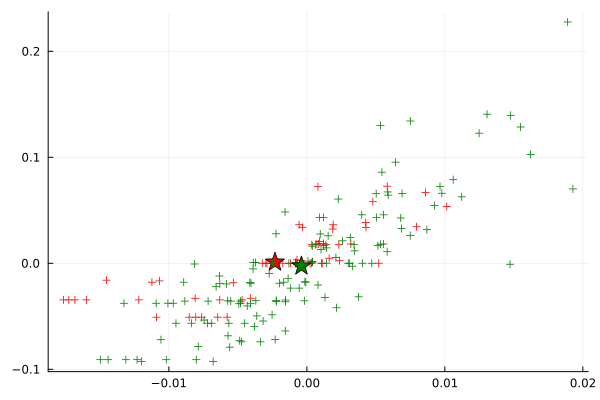

In [3]:
data = hf.merge_data(data_files,features)
hf.plot_observation_distributions(states,features,data)

In [4]:
@show trans_guess,dists_guess = hf.create_estimates(states,features,data_files)
init_guess = [0.5,0.5]

hmm_guess = hmms.HMM(init_guess, trans_guess, dists_guess)

@show obs_seq,seq_ends = hf.thread_observations(data_files,features)

@show hmm_est, llh_evolution = hmms.baum_welch(hmm_guess,obs_seq;seq_ends)

(trans_guess, dists_guess) = hf.create_estimates(states, features, data_files) = ([0.9285714285714286 0.07142857142857142; 0.022727272727272728 0.9772727272727273], Distributions.FullNormal[FullNormal(
dim: 17
μ: [-0.0023088524224179185, 0.0010985520653153747, -3.2311085447792394, -0.009350403843859037, 0.7287978055158866, 1.4010077988862886, 9.108675784558253, 25.706888767212405, -2.005614905064483, -2.0267019379883235, -1.5121970513653729, -0.01850797210822682, 0.06842399409808814, -0.0014757125587209928, 0.20110062180289764, 0.02330646775147798, -0.018793962782912545]
Σ: [0.00664800658232205 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.03270541248360589 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 2.811261912430945 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.01652729113769685 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.42705380052591796 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 

(Hidden Markov Model with:
 - initialization: [0.5000355392904975, 0.49996446070950257]
 - transition matrix: [0.95206369513431 0.047936304865690116; 0.06082874069131572 0.9391712593086844]
 - observation distributions: [FullNormal(
dim: 17
μ: [-0.002275651207382735, -0.006957079213781578, -1.1652762738266274, -0.006191555860753313, 0.7560830400124408, 1.5622331997979828, 11.296399290358163, 28.69656959439043, -1.5284060838869367, -1.5928776876778257, -1.146944087455468, -0.05171643496222515, 0.13875444506068926, -0.0016429786636641016, 0.132750170590712, -0.0012497542405405751, -0.052272846581605505]
Σ: [3.654912737413261e-5 0.0001475827221633403 0.00023542756825171982 5.7351707775110744e-5 -0.00016153397964827973 -0.004704409921966839 0.002511965006786649 -0.015911487929577486 0.003412768027144823 0.0026855038555715556 0.003552481033197894 -0.0005216831273540237 -0.0022000801357590664 -8.074040959895246e-6 -0.00039044288885846655 -0.0002107600070985672 -0.0005219528361042015; 0.00014

In [5]:
colors = ["red","green","blue"]
labels = ["Trust<0.5","Trust>0.5"]
shapes = [:circle, :square, :diamond, :hexagon, :cross, :xcross, :star4, :star6]

8-element Vector{Symbol}:
 :circle
 :square
 :diamond
 :hexagon
 :cross
 :xcross
 :star4
 :star6

In [6]:
best_state_seq, _ = hmms.viterbi(hmm_est,obs_seq;seq_ends)
tmp = [i for i in 1:DF.nrow(data)]

192-element Vector{Int64}:
   1
   2
   3
   4
   5
   6
   7
   8
   9
  10
   ⋮
 184
 185
 186
 187
 188
 189
 190
 191
 192

In [7]:
best_seqs = Vector{Vector{Int64}}()
#deconcatenate sequences
for i=1:length(seq_ends)
    start,stop = hmms.seq_limits(seq_ends,i)
    push!(best_seqs,best_state_seq[start:stop])
end

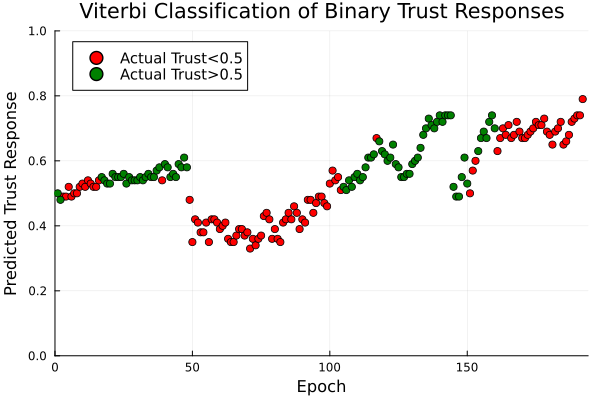

In [30]:
studies = unique(data.SessionID)
plt_viterbi = plt.scatter([],[],color="red",xlabel="Epoch",ylabel="Predicted Trust Response",ylim=(0,1),xlim=(0,194),label="Actual Trust<0.5")
plt.scatter!([],[],color="green",label="Actual Trust>0.5",title="Viterbi Classification of Binary Trust Responses",legendfontsize=10);

pop!(plt_viterbi.series_list)
for j=1:length(studies)
    data_subset = data[data.SessionID.==studies[j],:]
    for i=1:length(states)
        inds = findall(x -> x==i, best_seqs[j])
        x = tmp[inds].+(48*(j-1))
        y = data_subset.Trust[inds]
        plt.scatter!(x,y,color=colors[i],label=false)
    end
end

display(plt_viterbi)